In [36]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nba_api.stats.endpoints import leaguedashplayerstats, synergyplaytypes, leaguedashteamstats
from nba_api.stats.endpoints import teamyearbyyearstats, playercareerstats, teamplayeronoffdetails
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow, Rectangle
import matplotlib.ticker as mtick
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import functools
import seaborn as sns
import glob
from sklearn import preprocessing
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import gamma, exponpow, lognorm, cauchy, genhyperbolic
from datetime import date
from PIL import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
nopa_on = teamplayeronoffdetails.TeamPlayerOnOffDetails(measure_type_detailed_defense='Advanced',
                                                           per_mode_detailed='PerGame',
                                                           season='2023-24',
                                                           team_id=1610612740).get_data_frames()[1]
time.sleep(1)

nopa_off = teamplayeronoffdetails.TeamPlayerOnOffDetails(measure_type_detailed_defense='Advanced',
                                                           per_mode_detailed='PerGame',
                                                           season='2023-24',
                                                           team_id=1610612740).get_data_frames()[2]

In [21]:
def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=player_zoom)

def get_team_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'team_imgs/{player_id}.png'), zoom=team_zoom)

In [140]:
zion_on = nopa_on[nopa_on.VS_PLAYER_ID == find_players_by_full_name('Zion Williamson')[0]['id']]
zion_off = nopa_off[nopa_off.VS_PLAYER_ID == find_players_by_full_name('Zion Williamson')[0]['id']]

ingram_on = nopa_on[nopa_on.VS_PLAYER_ID == find_players_by_full_name('Brandon Ingram')[0]['id']]
ingram_off = nopa_off[nopa_off.VS_PLAYER_ID == find_players_by_full_name('Brandon Ingram')[0]['id']]

both_on_off_rtg = 120.49
both_on_def_rtg = 113.42
both_on_min = 338

both_off_off_rtg = 113.87
both_off_def_rtg = 104.62
both_off_min = 180

both_on_net_rtg = np.round(both_on_off_rtg - both_on_def_rtg, 1)
both_off_net_rtg = np.round(both_off_off_rtg - both_off_def_rtg, 1)

print(zion_on.MIN, zion_off.MIN)
print(ingram_on.MIN, ingram_off.MIN)

16    562.0
Name: MIN, dtype: float64 16    494.0
Name: MIN, dtype: float64
4    652.0
Name: MIN, dtype: float64 4    404.0
Name: MIN, dtype: float64


In [37]:
team_stats_advanced = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense='Advanced',
                                                              season_type_all_star='Regular Season',
                                                              season='2023-24', 
                                                              league_id_nullable='00',                                                              
                                                              ).get_data_frames()[0]

team_stats_advanced

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,...,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK
0,1610612737,Atlanta Hawks,19,9,10,0.474,917.0,116.5,118.6,116.5,...,19,26,3,25,14,16,10,7,3,20
1,1610612738,Boston Celtics,20,15,5,0.750,970.0,114.3,116.7,106.6,...,21,21,16,3,3,18,4,6,21,2
2,1610612751,Brooklyn Nets,19,10,9,0.526,917.0,115.5,117.5,112.7,...,9,13,10,10,4,14,6,10,23,12
3,1610612766,Charlotte Hornets,18,6,12,0.333,869.0,111.6,113.0,117.9,...,16,20,12,19,15,17,21,22,14,23
4,1610612741,Chicago Bulls,21,7,14,0.333,1023.0,108.5,109.7,113.0,...,13,28,20,24,28,3,28,28,30,24
5,1610612739,Cleveland Cavaliers,20,11,9,0.550,965.0,109.9,110.7,108.8,...,23,16,21,22,23,20,18,19,17,14
6,1610612742,Dallas Mavericks,19,11,8,0.579,912.0,114.9,117.4,115.0,...,3,22,24,26,29,1,7,12,9,21
7,1610612743,Denver Nuggets,21,14,7,0.667,1008.0,114.0,117.0,111.1,...,2,1,13,8,10,5,5,14,26,7
8,1610612765,Detroit Pistons,20,2,18,0.100,960.0,106.1,108.2,115.0,...,28,14,11,6,8,29,27,25,7,28
9,1610612744,Golden State Warriors,20,9,11,0.450,965.0,111.8,113.7,111.5,...,15,6,7,12,9,23,22,18,13,19


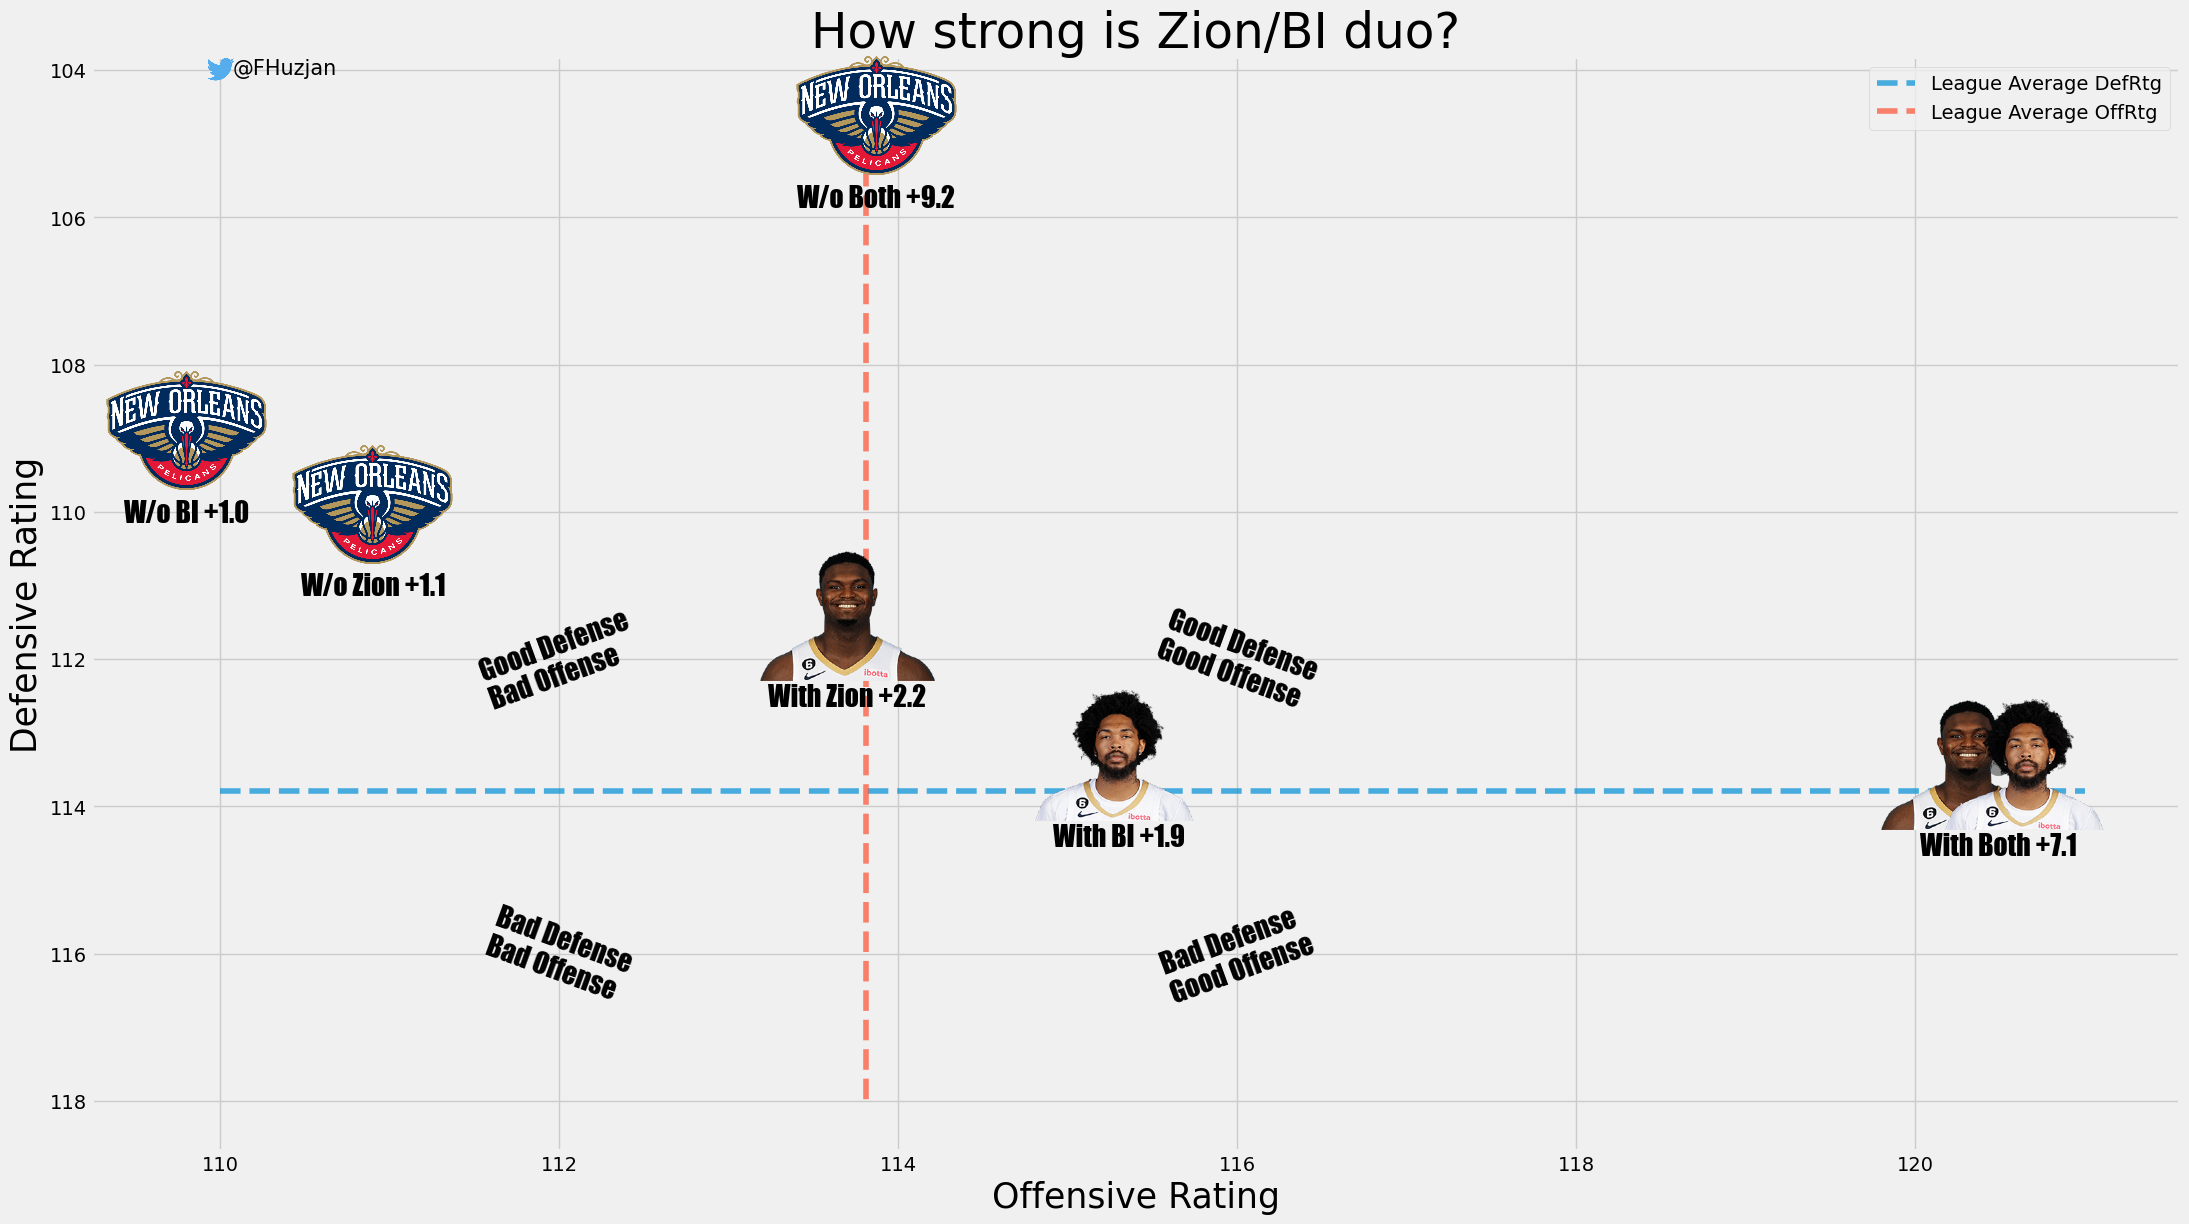

In [142]:
scaler = 1.5

fig = plt.figure(figsize=(16 * scaler, 9 * scaler))
ax = plt.subplot()

team_zoom = 0.17
player_zoom = 0.5

# minutes = [float(zion_on.MIN), float(zion_off.MIN), float(ingram_on.MIN), float(ingram_off.MIN), both_on_min, both_off_min]
# minutes = [float(i)/max(minutes) * 500 for i in minutes]

avg_off_rtg = np.mean(team_stats_advanced.OFF_RATING)
avg_def_rtg = np.mean(team_stats_advanced.DEF_RATING)

textprops = {"family" : "fantasy", "size" : 20}
textprops2 = {"family" : "fantasy", "size" : 20, "rotation" : 360 -45}


ax.scatter(zion_on.OFF_RATING, zion_on.DEF_RATING, s=minutes[0])
ab = AnnotationBbox(get_player_img(find_players_by_full_name('Zion Williamson')[0]['id']), (zion_on.OFF_RATING, zion_on.DEF_RATING), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'With Zion +{float(zion_on.NET_RATING)}', textprops=textprops), (zion_on.OFF_RATING, zion_on.DEF_RATING + 1.1), frameon=False)
ax.add_artist(ab)
# ab = AnnotationBbox(TextArea(f'{int(zion_on.MIN)} MP', textprops=textprops), (zion_on.OFF_RATING, zion_on.DEF_RATING - 1), frameon=False)
# ax.add_artist(ab)

ax.scatter(zion_off.OFF_RATING, zion_off.DEF_RATING, s=minutes[1])
ab = AnnotationBbox(get_team_img(1610612740), (zion_off.OFF_RATING, zion_off.DEF_RATING), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'W/o Zion +{float(zion_off.NET_RATING)}', textprops=textprops), (zion_off.OFF_RATING, zion_off.DEF_RATING + 1.1), frameon=False)
ax.add_artist(ab)
# ab = AnnotationBbox(TextArea(f'{int(zion_off.MIN)} min', textprops=textprops), (zion_off.OFF_RATING, zion_off.DEF_RATING - 1), frameon=False)
# ax.add_artist(ab)

ax.scatter(ingram_on.OFF_RATING, ingram_on.DEF_RATING, s=minutes[2])
ab = AnnotationBbox(get_player_img(find_players_by_full_name('Brandon Ingram')[0]['id']), (ingram_on.OFF_RATING, ingram_on.DEF_RATING), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'With BI +{float(ingram_on.NET_RATING)}', textprops=textprops), (ingram_on.OFF_RATING, ingram_on.DEF_RATING + 1.1), frameon=False)
ax.add_artist(ab)
# ab = AnnotationBbox(TextArea(f'{int(ingram_on.MIN)}', textprops=textprops), (ingram_on.OFF_RATING, ingram_on.DEF_RATING - 1), frameon=False)
# ax.add_artist(ab)

ax.scatter(ingram_off.OFF_RATING, ingram_off.DEF_RATING, s=minutes[3])
ab = AnnotationBbox(get_team_img(1610612740), (ingram_off.OFF_RATING, ingram_off.DEF_RATING), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'W/o BI +{float(ingram_off.NET_RATING)}', textprops=textprops), (ingram_off.OFF_RATING, ingram_off.DEF_RATING + 1.1), frameon=False)
ax.add_artist(ab)
# ab = AnnotationBbox(TextArea(f'{int(ingram_off.MIN)} min', textprops=textprops), (ingram_off.OFF_RATING, ingram_off.DEF_RATING - 1), frameon=False)
# ax.add_artist(ab)

ax.scatter(both_on_off_rtg, both_on_def_rtg, s=minutes[4])
ab = AnnotationBbox(get_player_img(find_players_by_full_name('Zion Williamson')[0]['id']), (both_on_off_rtg - 0.175, both_on_def_rtg), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(get_player_img(find_players_by_full_name('Brandon Ingram')[0]['id']), (both_on_off_rtg + 0.175, both_on_def_rtg), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'With Both +{float(both_on_net_rtg)}', textprops=textprops), (both_on_off_rtg, both_on_def_rtg + 1.1), frameon=False)
ax.add_artist(ab)
# ab = AnnotationBbox(TextArea(f'{int(both_on_min)} min', textprops=textprops), (both_on_off_rtg, both_on_def_rtg - 1), frameon=False)
# ax.add_artist(ab)

ax.scatter(both_off_off_rtg, both_off_def_rtg, s=minutes[5])
ab = AnnotationBbox(get_team_img(1610612740), (both_off_off_rtg, both_off_def_rtg), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'W/o Both +{float(both_off_net_rtg)}', textprops=textprops), (both_off_off_rtg, both_off_def_rtg + 1.1), frameon=False)
ax.add_artist(ab)
# ab = AnnotationBbox(TextArea(f'{int(both_on_min)} min', textprops=textprops), (both_on_off_rtg, both_on_def_rtg - 1), frameon=False)
# ax.add_artist(ab)

ax.plot([110, 121], [avg_def_rtg, avg_def_rtg], '--', alpha=0.7, label='League Average DefRtg')
ax.plot([avg_off_rtg, avg_off_rtg], [104.5, 118], '--', alpha=0.7, label='League Average OffRtg')

ab = AnnotationBbox(TextArea(f'Good Defense\nGood Offense', textprops={"family" : "fantasy", "size" : 20, "rotation" : 340}), (116, 112), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'Good Defense\nBad Offense', textprops={"family" : "fantasy", "size" : 20, "rotation" : 20}), (112, 112), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'Bad Defense\nBad Offense', textprops={"family" : "fantasy", "size" : 20, "rotation" : 340}), (112, 116), frameon=False)
ax.add_artist(ab)
ab = AnnotationBbox(TextArea(f'Bad Defense\nGood Offense', textprops={"family" : "fantasy", "size" : 20, "rotation" : 20}), (116, 116), frameon=False)
ax.add_artist(ab)

plt.legend()
ax.set_xlabel('Offensive Rating', fontsize=25)
ax.set_ylabel('Defensive Rating', fontsize=25)
ax.set_title('How strong is Zion/BI duo?', fontsize=35)
ab = AnnotationBbox(OffsetImage(plt.imread(f'twitter_logo (1).png'), zoom=0.1), (110, 104), frameon=False)
ax.add_artist(ab)
ax.text(x=110.075, y=104.05, ha='left', s='@FHuzjan', size=15)
ax.invert_yaxis()
plt.savefig('Graphs/zion_bi.png', bbox_inches='tight')